# Example 2 with `pymc` models

This notebook shows an example of using synthetic control in a situation where we do not have untreated control units of a similar nature to the treated unit. So in this example we just have a single time series of observations and the predictor variables are simply time and month.

In [1]:
import arviz as az
import pandas as pd

import causalpy as cp

In [2]:
%load_ext autoreload
%autoreload 2
# %config InlineBackend.figure_format = 'svg'

## Example

Load data

In [3]:
df = cp.load_data("its")
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)
treatment_time = pd.to_datetime("2017-01-01")
df.head()

,month,year,t,y
date,,,,
2010-01-31,1,2010,0,25.058186
2010-02-28,2,2010,1,27.189812
2010-03-31,3,2010,2,26.487551
2010-04-30,4,2010,3,31.241716
2010-05-31,5,2010,4,40.753973


Run the analysis

In [4]:
result = cp.pymc_experiments.SyntheticControl(
    df,
    treatment_time,
    formula="y ~ 1 + t + C(month)",
    prediction_model=cp.pymc_models.LinearRegression(),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


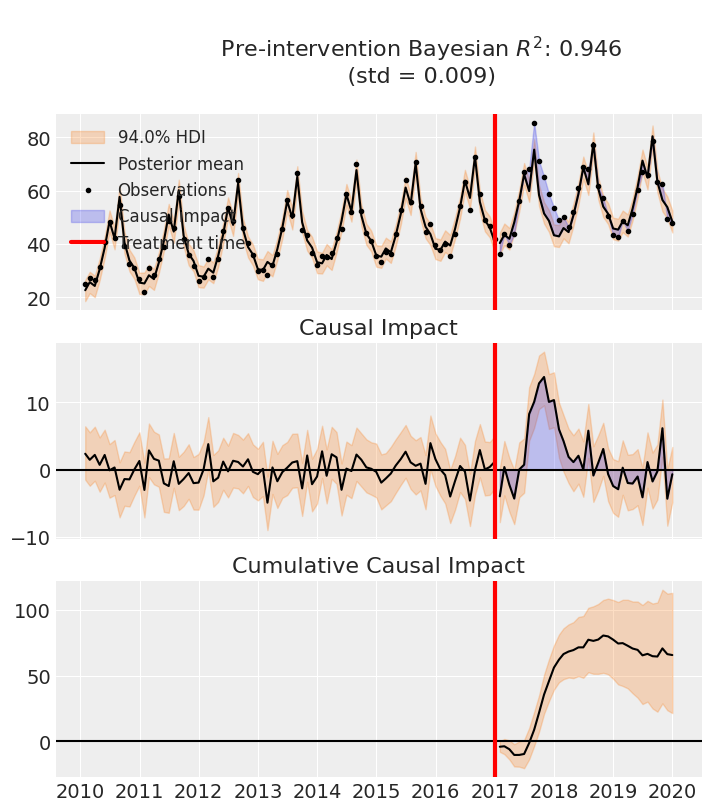

In [5]:
fig, ax = result.plot()

In [6]:
result.summary()

===============================Synthetic Control================================
Formula: y ~ 1 + t + C(month)
Model coefficients:

                Intercept                     22.68,
                94% HDI [21.15,
                24.25]
                

                C(month)[T.2]                 2.87,
                94% HDI [0.85,
                4.83]
                

                C(month)[T.3]                 1.18,
                94% HDI [-0.84,
                3.08]
                

                C(month)[T.4]                 7.18,
                94% HDI [5.20,
                9.14]
                

                C(month)[T.5]                 15.06,
                94% HDI [13.04,
                17.01]
                

                C(month)[T.6]                 24.81,
                94% HDI [22.79,
                26.82]
                

                C(month)[T.7]                 18.23,
                94% HDI [16.23,
                20.20]
            

As well as the model coefficients, we might be interested in the avarage causal impact and average cumulative causal impact.

<div class="alert alert-info">

Note

Better output for the summary statistics are in progress!

</div>

First we ask for summary statistics of the causal impact over the entire post-intervention period.

In [7]:
az.summary(result.post_impact.mean("obs_ind"))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,1.82,0.672,0.598,3.129,0.012,0.008,3397.0,3410.0,1.0


<div class="alert alert-warning">

Warning

Care must be taken with the mean impact statistic. It only makes sense to use this statistic if it looks like the intervention had a lasting (and roughly constant) effect on the outcome variable. If the effect is transient, then clearly there will be a lot of post-intervention period where the impact of the intervention has 'worn off'. If so, then it will be hard to interpret the mean impacts real meaning.

</div>

We can also ask for the summary statistics of the _cumulative_ causal impact.

In [8]:
# get index of the final time point
index = result.post_impact_cumulative.obs_ind.max()
# grab the posterior distribution of the cumulative impact at this final time point
last_cumulative_estimate = result.post_impact_cumulative.sel({"obs_ind": index})
# get summary stats
az.summary(last_cumulative_estimate)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,65.526,24.195,21.531,112.631,0.415,0.294,3397.0,3410.0,1.0
